In [154]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [155]:
class Environment:
    def __init__(self, n_states = 1000, n_actions = 2, branching_factor = 2, terminal_transition_probability = 0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.branching_factor = branching_factor
        self.terminal_transition_probability = terminal_transition_probability

        self.start_state = 0
        self.terminal_state = n_states - 1
        self.n_non_terminal_states = n_states - 1
    
        self.init_transitions()

    def init_transitions(self):
        self.transitions = {}
        self.rewards = {}
        for state in range(self.n_non_terminal_states):
            self.transitions[state] = {}
            self.rewards[state] = {}
            for action in range(self.n_actions):
                self.transitions[state][action] = random.sample(range(self.n_states), k=self.branching_factor)
                self.rewards[state][action] = random.normalvariate(0, 1)
    
    def step(self, state, action):
        reward = self.rewards[state][action]

        if random.random() < self.terminal_transition_probability:
            next_state = self.terminal_state
            done = True
        else:
            next_state = random.choice(self.transitions[state][action])
            done = next_state == self.terminal_state

        return next_state, reward, done
    
    def valid_actions(self, state):
        return list(range(self.n_actions))

    def all_possible_states(self):
        return list(range(self.n_states))
    
    def non_terminal_states(self):
        return list(range(self.n_non_terminal_states))

In [156]:
def expected_value(env, state, action, Q, gamma=1):
    transition = env.transitions[state][action]
    reward = env.rewards[state][action]

    res = reward + (1 - env.terminal_transition_probability) * gamma * np.mean([max(Q[next_state].values()) for next_state in transition]).item()

    return res

In [157]:
class Policy:
    def __init__(self, env, epsilon=0.1):
        self.env = env
        self.epsilon = epsilon

        self.Q = {
            state: {action: 0 for action in env.valid_actions(state)}
            for state in env.all_possible_states()
        }

    def action(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(list(self.Q[state].keys()))
        else:
            return self.greedy_action(state)

    def greedy_action(self, state):
        max_value = max(self.Q[state].values())
        actions = [action for action, value in self.Q[state].items() if value == max_value]
        action = random.choice(actions)
        return action

    def update(self, state, action, new_value):
        self.Q[state][action] = new_value

In [158]:
env = Environment()
policy = Policy(env)

In [159]:
def start_state_true_value_MC(env, policy, episodes=1):
    rewards = []

    for _ in range(episodes):
        state = env.start_state
        total_reward = 0
        steps = 0

        while state != env.terminal_state:
            action = policy.greedy_action(state)
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            state = next_state
            steps += 1

        rewards.append(total_reward)

    return np.mean(rewards).item()

In [165]:
def state_new_estimate(env, policy, state, V, gamma=1):
    if state == env.terminal_state:
        return 0

    action = policy.greedy_action(state)
    transition = env.transitions[state][action]
    reward = env.rewards[state][action]

    res = (
        reward
        + (1 - env.terminal_transition_probability)
        * gamma
        * np.mean([V[next_state] for next_state in transition]).item()
    )

    return res


def generate_episode(env, policy):
    state = env.start_state
    episode = [state]

    while state != env.terminal_state:
        action = policy.action(state)
        next_state, reward, done = env.step(state, action)
        state = next_state
        episode.append(state)

    return episode


def generate_episode_with_branches(env, policy):
    state = env.start_state
    episode = [state]

    while state != env.terminal_state:
        action = policy.action(state)
        next_state, reward, done = env.step(state, action)
        state = next_state
        episode += env.transitions[state][action]  # Add branches to the episode
        episode.append(state)

    return episode


def start_state_true_value(env, policy, diff_threshold=0.001):
    V = {
        state: policy.Q[state][policy.greedy_action(state)]
        for state in env.all_possible_states()
    }

    done = False

    while not done:
        episode = generate_episode(env, policy)
        # episode = generate_episode_with_branches(env, policy)
        done = True
        for state in episode[::-1]:
            v = V[state]
            V[state] = state_new_estimate(env, policy, state, V)
            if abs(v - V[state]) > diff_threshold:
                done = False

    return V[env.start_state]

In [166]:
def evaluate(env, q, state, depth=10):
    if depth == 0:
        return max(q[state].values())

    action = max(q[state], key=q[state].get)

    reward = env.rewards[state][action]
    next_states = env.transitions[state][action]

    return reward + (1 - env.terminal_transition_probability) * np.mean(
        [evaluate(env, q, next_state, depth - 1) for next_state in next_states]
    )

In [ ]:
def update_uniform(env, policy=None, n_updates=20000):
    if policy is None:
        policy = Policy(env)

    done_updates = 0

    start_state_values = [start_state_true_value(env, policy)]

    while True:
        for state in env.non_terminal_states():
            for action in env.valid_actions(state):
                exp_value = expected_value(env, state, action, policy.Q)
                policy.update(state, action, exp_value)

                done_updates += 1

                if done_updates % 100 == 0:
                    start_state_value = start_state_true_value(env, policy)
                    # start_state_value = start_state_true_value_MC(env, policy, episodes=100)
                    # start_state_value = evaluate(env, policy.Q, env.start_state)

                    start_state_values.append(start_state_value)

                if done_updates >= n_updates:
                    return start_state_values

In [187]:
def update_on_policy(env, policy=None, n_updates=20000):
    if policy is None:
        policy = Policy(env)

    done_updates = 0

    start_state_values = [start_state_true_value(env, policy)]

    while True:
        state = env.start_state
        while state != env.terminal_state:
            action = policy.action(state)
            next_state, reward, done = env.step(state, action)

            exp_value = expected_value(env, state, action, policy.Q)
            policy.update(state, action, exp_value)

            state = next_state

            done_updates += 1

            if done_updates % 100 == 0:
                start_state_value = start_state_true_value(env, policy)
                # start_state_value = start_state_true_value_MC(env, policy, episodes=100)
                # start_state_value = evaluate(env, policy.Q, env.start_state)

                start_state_values.append(start_state_value)

            if done_updates >= n_updates:
                return start_state_values

In [181]:
values = []
env = Environment(branching_factor=1, n_states=1000)
n_updates = 20000

for i in tqdm(range(200)):
    policy = Policy(env)
    values.append(update_uniform(env, policy=policy, n_updates=n_updates))

mean_values_uniform_b1 = np.mean(values, axis=0)

100%|██████████| 200/200 [01:06<00:00,  3.03it/s]


In [188]:
values = []

for i in tqdm(range(200)):
    policy = Policy(env)
    values.append(update_on_policy(env, policy=policy, n_updates=n_updates))

mean_values_on_policy_b1 = np.mean(values, axis=0)

100%|██████████| 200/200 [01:26<00:00,  2.30it/s]


In [ ]:
env = Environment(branching_factor=3, n_states=1000)

values = []

for i in tqdm(range(200)):
    policy = Policy(env)
    values.append(update_uniform(env, policy=policy, n_updates=n_updates))

mean_values_uniform_b3 = np.mean(values, axis=0)

In [190]:
values = []

for i in tqdm(range(200)):
    policy = Policy(env)
    values.append(update_on_policy(env, policy=policy, n_updates=n_updates))

mean_values_on_policy_b3 = np.mean(values, axis=0)

100%|██████████| 200/200 [01:26<00:00,  2.31it/s]


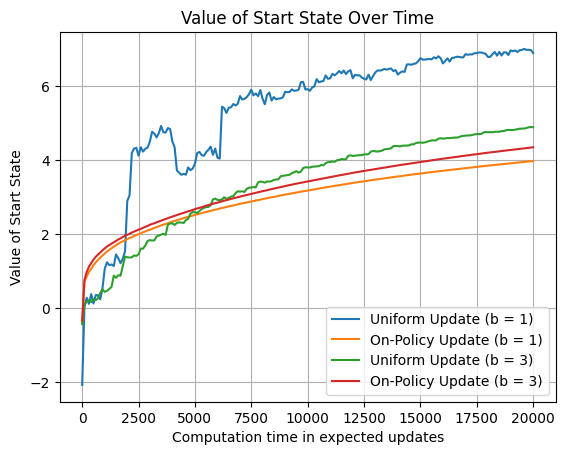

In [191]:
ploted_timesteps = list(range(0, 20001, 100))

plt.plot(ploted_timesteps, mean_values_uniform_b1, label='Uniform Update (b = 1)')
plt.plot(ploted_timesteps, mean_values_on_policy_b1, label='On-Policy Update (b = 1)')

plt.plot(ploted_timesteps, mean_values_uniform_b3, label='Uniform Update (b = 3)')
plt.plot(ploted_timesteps, mean_values_on_policy_b3, label='On-Policy Update (b = 3)')

plt.xlabel('Computation time in expected updates')
plt.ylabel('Value of Start State')
plt.title('Value of Start State Over Time')
plt.grid()
plt.legend()
plt.show()